# Importations of libraries

In [4]:
from ppca_optimized import PPCA

import numpy as np
import matplotlib.pyplot as plt
import plotly
import pandas
from numpy import linalg

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import fetch_olivetti_faces

import torch
from torch import nn
import torch.nn.functional as F
from skimage import io, color
from skimage.metrics import structural_similarity as ssim

import random
import time

import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, STL10
from torch.utils.data import DataLoader


# Missing Data Imputation with PPCA

### Example Implementation for Image Reconstruction:

In [2]:
def apply_ppca_to_image_patches(image, patch_size=(8, 8), n_components=5, **ppca_kwargs):
    # Ensure image is 4D: (batch=1, channels, height, width)
    if image.dim() == 2:
        # Grayscale: (H, W) → (1, 1, H, W)
        image = image.unsqueeze(0).unsqueeze(0)
    elif image.dim() == 3:
        # Color: (C, H, W) → (1, C, H, W)
        image = image.unsqueeze(0)
    
    # Verify patch size compatibility
    H, W = image.shape[2], image.shape[3]
    if H < patch_size[0] or W < patch_size[1]:
        raise ValueError(f"Image size ({H}x{W}) is smaller than patch size {patch_size}.")
    
    # Extract patches using F.unfold (shape: [1, C*ph*pw, L])
    patches = F.unfold(image, kernel_size=patch_size, stride=1)
    patches_flat = patches.squeeze(0).T  # Reshape to [L, C*ph*pw]
    
    # Train PPCA
    ppca = PPCA_GPU_Optimized(n_components, **ppca_kwargs)
    ppca.fit(patches_flat)
    
    # Reconstruct patches
    recon_patches = ppca.reconstruct(patches_flat).T.unsqueeze(0)
    
    # Fold back into image
    output = F.fold(
        recon_patches,
        output_size=(H, W),
        kernel_size=patch_size,
        stride=1
    )
    
    # Normalize overlapping regions
    ones = torch.ones_like(recon_patches)
    counter = F.fold(ones, output_size=(H, W), kernel_size=patch_size, stride=1)
    counter[counter == 0] = 1
    return (output / counter).squeeze()

**Application on Grayscale Image Reconstruction**

In [5]:
dataset = fetch_olivetti_faces(shuffle=True).data
print(f'This dataset contains {len(dataset)} images')

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
This dataset contains 400 images


Image 1:
PPCA - RMSE: 0.0940, SSIM: 0.8851, Time: 0.00s
Baseline - RMSE: 0.1826, SSIM: 0.7158


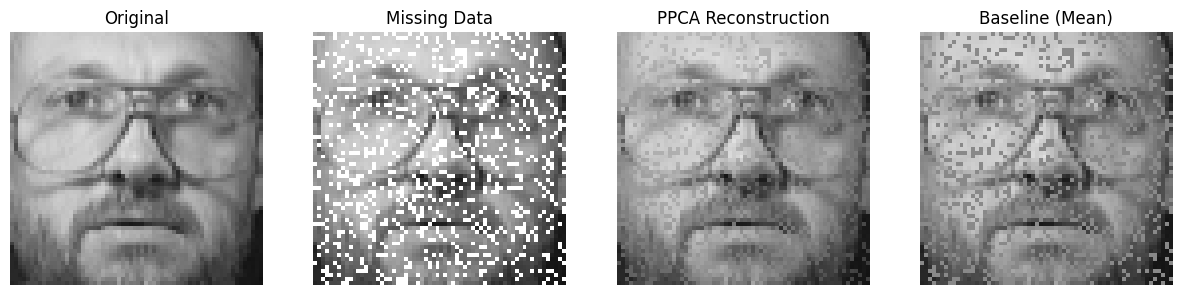

Image 2:
PPCA - RMSE: 0.0900, SSIM: 0.9182, Time: 0.00s
Baseline - RMSE: 0.1414, SSIM: 0.8017


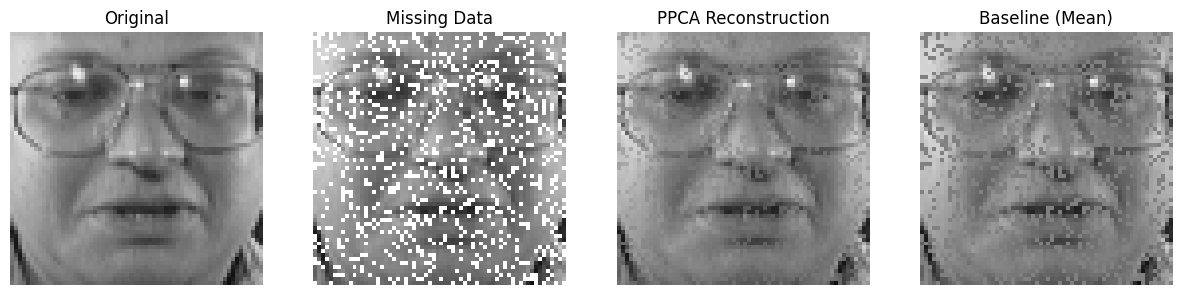

Image 3:
PPCA - RMSE: 0.0843, SSIM: 0.8935, Time: 0.00s
Baseline - RMSE: 0.1664, SSIM: 0.7041


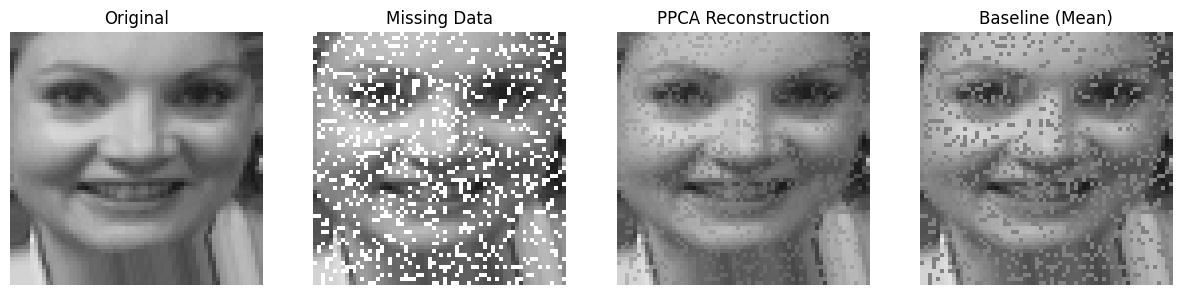

Image 4:
PPCA - RMSE: 0.0957, SSIM: 0.9062, Time: 0.00s
Baseline - RMSE: 0.1642, SSIM: 0.7587


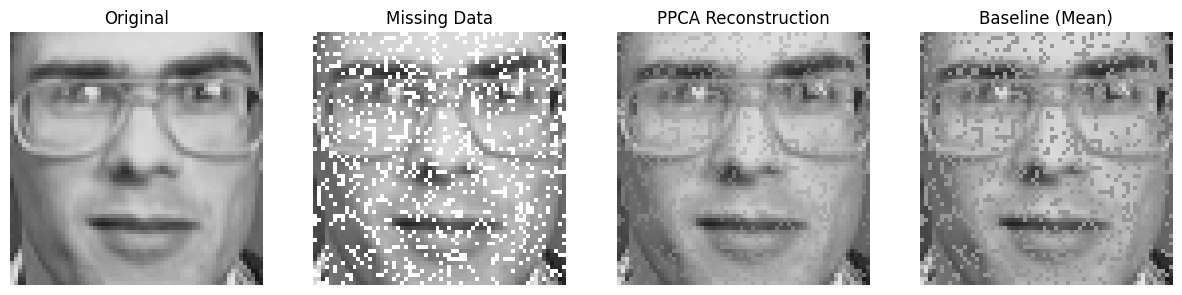

Image 5:
PPCA - RMSE: 0.0757, SSIM: 0.8777, Time: 0.00s
Baseline - RMSE: 0.1532, SSIM: 0.6786


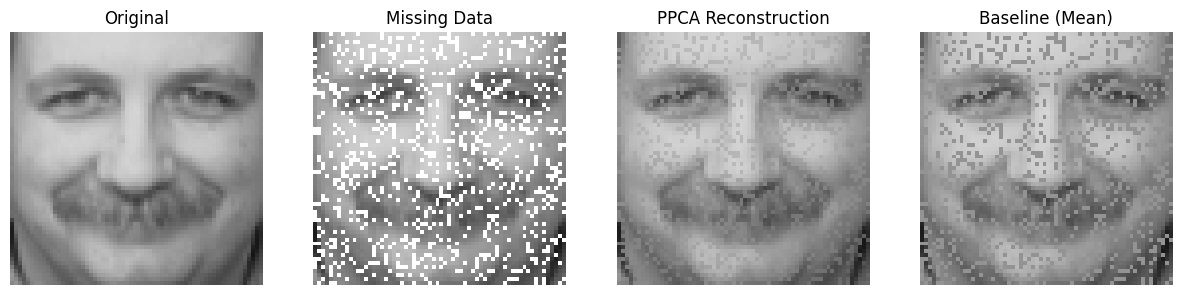

Image 6:
PPCA - RMSE: 0.0913, SSIM: 0.9042, Time: 0.00s
Baseline - RMSE: 0.1647, SSIM: 0.7357


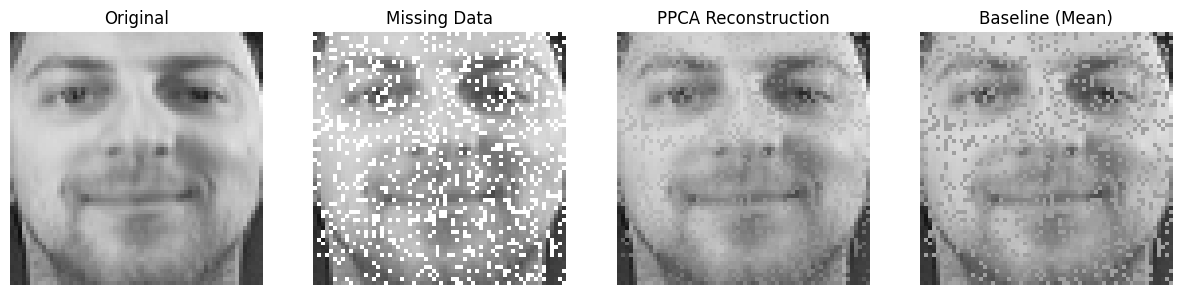

Image 7:
PPCA - RMSE: 0.0851, SSIM: 0.9082, Time: 0.00s
Baseline - RMSE: 0.1548, SSIM: 0.7458


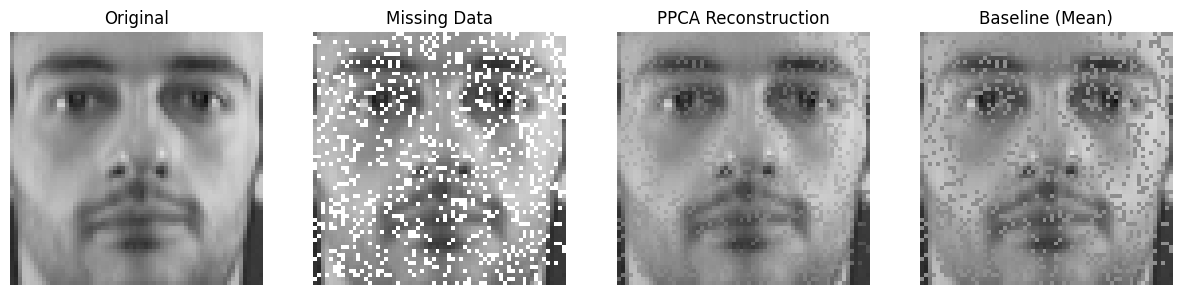

Image 8:
PPCA - RMSE: 0.1025, SSIM: 0.8894, Time: 0.00s
Baseline - RMSE: 0.1796, SSIM: 0.7589


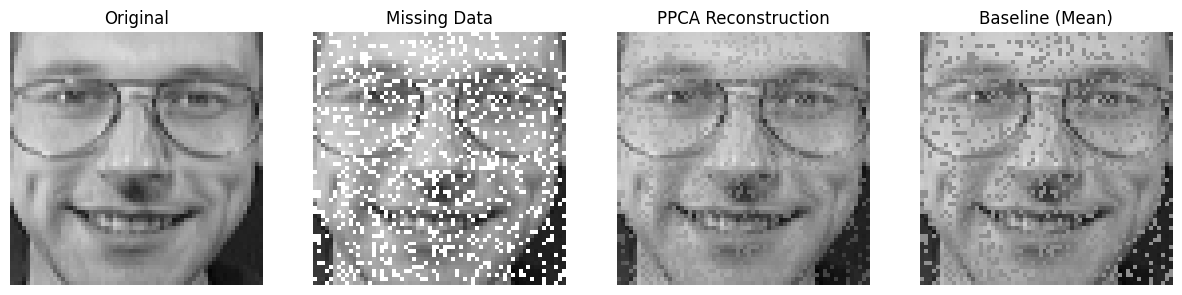

Image 9:
PPCA - RMSE: 0.0603, SSIM: 0.9104, Time: 0.00s
Baseline - RMSE: 0.1172, SSIM: 0.7560


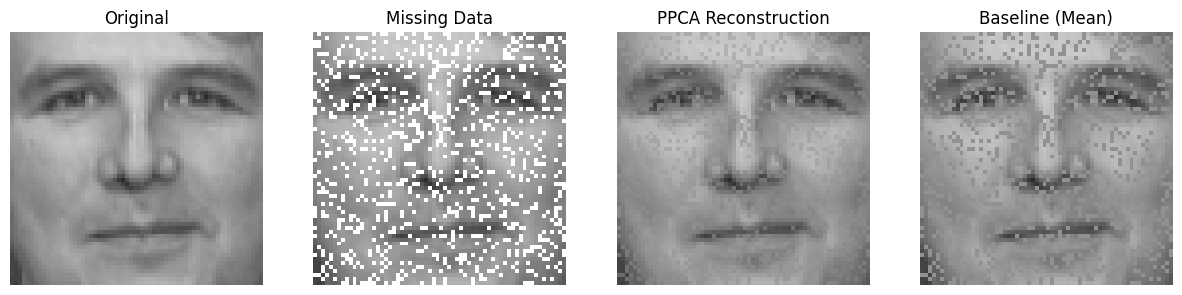

Image 10:
PPCA - RMSE: 0.0813, SSIM: 0.9224, Time: 0.00s
Baseline - RMSE: 0.1359, SSIM: 0.8034


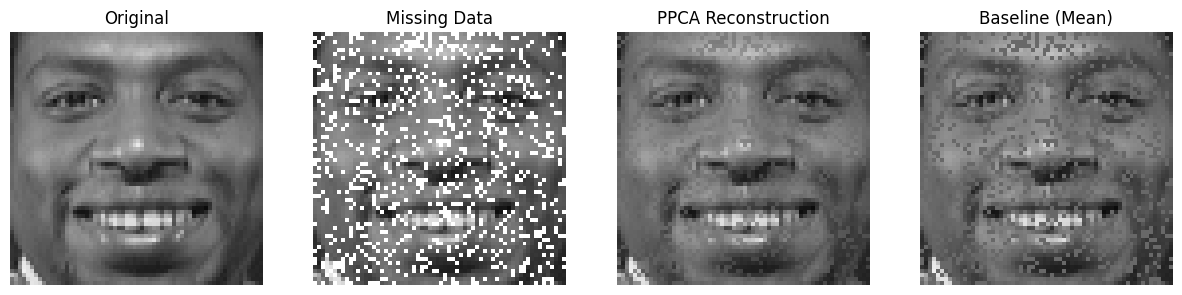

In [7]:
# Function to perform mean imputation (baseline) on GPU
def mean_imputation(image_missing):
    mean_value = torch.nanmean(image_missing)
    image_imputed = torch.where(torch.isnan(image_missing), mean_value, image_missing)
    return image_imputed

# Initialize lists for metrics
rmse_ppca_all = []
ssim_ppca_all = []
rmse_baseline_all = []
ssim_baseline_all = []
runtime_ppca_all = []
runtime_baseline_all = []
# Set device and mixed precision
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float32  # Use torch.float16 for mixed precision if supported

# Iterate through dataset (assuming dataset is a list of numpy arrays)
for i, image in enumerate(dataset):
    # Convert to PyTorch tensor and move to GPU
    image_gray = torch.tensor(image.reshape(64, 64), dtype=dtype, device=device)
    
    # Introduce missing data on GPU
    missing_rate = 0.2
    missing_mask = torch.rand(*image_gray.shape, device=device) < missing_rate
    image_missing = image_gray.clone()
    image_missing[missing_mask] = torch.nan
    
    # PPCA Reconstruction (GPU-optimized)
    start_time = time.time()
    image_reconstructed = apply_ppca_to_image_patches(
        image_missing, 
        patch_size=(8, 8), 
        n_components=20, 
        stochastic_em=False,
        device=device,
        fp16=False  # Set True if using mixed precision
    )
    end_time = time.time()
    
    # Move reconstructed data to CPU for evaluation
    image_reconstructed_cpu = image_reconstructed.cpu().numpy()
    image_gray_cpu = image_gray.cpu().numpy()
    missing_mask_cpu = missing_mask.cpu().numpy()
    
    # Evaluate PPCA performance
    original_pixels = image_gray_cpu[missing_mask_cpu]
    reconstructed_pixels_ppca = image_reconstructed_cpu[missing_mask_cpu]
    rmse_ppca = np.sqrt(np.nanmean((original_pixels - reconstructed_pixels_ppca) ** 2))
    ssim_ppca = ssim(image_gray_cpu, image_reconstructed_cpu, 
                     data_range=image_reconstructed_cpu.max() - image_reconstructed_cpu.min())
    
    rmse_ppca_all.append(rmse_ppca)
    ssim_ppca_all.append(ssim_ppca)
    runtime_ppca_all.append(end_time - start_time)
    
    # Baseline Reconstruction (Mean Imputation on GPU)
    image_baseline = mean_imputation(image_missing)
    start_time = time.time()
    image_baseline_cpu = image_baseline.cpu().numpy()
    reconstructed_pixels_baseline = image_baseline_cpu[missing_mask_cpu]
    end_time = time.time()
    rmse_baseline = np.sqrt(np.nanmean((original_pixels - reconstructed_pixels_baseline) ** 2))
    ssim_baseline = ssim(image_gray_cpu, image_baseline_cpu, 
                         data_range=image_baseline_cpu.max() - image_baseline_cpu.min())
    runtime_baseline_all.append(end_time - start_time)
    rmse_baseline_all.append(rmse_baseline)
    ssim_baseline_all.append(ssim_baseline)
    if i <= 9:
        print(f"Image {i+1}:")
        print(f"PPCA - RMSE: {rmse_ppca:.4f}, SSIM: {ssim_ppca:.4f}, Time: {end_time - start_time:.2f}s")
        print(f"Baseline - RMSE: {rmse_baseline:.4f}, SSIM: {ssim_baseline:.4f}")
    
        # Visualization (using CPU data)
        plt.figure(figsize=(15, 5))
        titles = ['Original', 'Missing Data', 'PPCA Reconstruction', 'Baseline (Mean)']
        images = [image_gray_cpu, image_missing.cpu().numpy(), image_reconstructed_cpu, image_baseline_cpu]
        
        for j in range(4):
            plt.subplot(1, 4, j+1)
            plt.title(titles[j])
            plt.imshow(images[j], cmap='gray', vmin=0, vmax=1)
            plt.axis('off')
        plt.show()

# Aggregate Results (unchanged)
mean_rmse_ppca = np.mean(rmse_ppca_all)
std_rmse_ppca = np.std(rmse_ppca_all)
mean_ssim_ppca = np.mean(ssim_ppca_all)
std_ssim_ppca = np.std(ssim_ppca_all)

mean_rmse_baseline = np.mean(rmse_baseline_all)
std_rmse_baseline = np.std(rmse_baseline_all)
mean_ssim_baseline = np.mean(ssim_baseline_all)
std_ssim_baseline = np.std(ssim_baseline_all)

mean_runtime_ppca = np.mean(runtime_ppca_all)
mean_runtime_baseline = np.mean(runtime_baseline_all)

In [10]:
import pandas as pd
# Create a dictionary to store the results
results = {
    "Method": ["PPCA", "Baseline"],
    "Mean RMSE": [mean_rmse_ppca, mean_rmse_baseline],
    "Std RMSE": [std_rmse_ppca, std_rmse_baseline],
    "Mean SSIM": [mean_ssim_ppca, mean_ssim_baseline],
    "Std SSIM": [std_ssim_ppca, std_ssim_baseline],
    "Mean Runtime (s)": [mean_runtime_ppca, mean_runtime_baseline]  # Baseline runtime not provided
}

# Convert the dictionary to a pandas DataFrame
df_results = pd.DataFrame(results)

# Display the DataFrame
df_results

,Method,Mean RMSE,Std RMSE,Mean SSIM,Std SSIM,Mean Runtime (s)
0,PPCA,0.082073,0.01291,0.891385,0.023277,0.182001
1,Baseline,0.158221,0.02671,0.717004,0.048744,0.000080


**Application for colored Image Reconstruction**

In [36]:
# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
"""
dataset = CIFAR10(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
"""
# Alternatively, load STL-10 dataset
dataset = STL10(root="./data", split="train", download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

100%|██████████| 2.64G/2.64G [03:00<00:00, 14.7MB/s] 


Extracting ./data/stl10_binary.tar.gz to ./data


In [69]:
def test_ppca_on_colored_image(dataloader, patch_size=(8, 8), n_components=8, missing_rate=0.3):

    for i in range(20):
        # Load image and ensure correct shape
        image, _ = next(iter(dataloader))  # Shape: [1, 3, 32, 32]
        image = image.squeeze(0)  # → [3, 32, 32]
        
        # Verify dimensions
        print(f"Image shape: {image.shape}")  # Debug line
        
        # Move to GPU
        device = "cuda" if torch.cuda.is_available() else "cpu"
        image = image.to(device)
        
        # Introduce missing data
        missing_mask = torch.rand(*image.shape[1:], device=device) < missing_rate
        missing_mask = missing_mask.unsqueeze(0).expand_as(image)
        image_missing = image.clone()
        image_missing[missing_mask] = torch.nan
        
        # Reconstruct
        start_time = time.time()
        image_reconstructed = apply_ppca_to_image_patches(
            image_missing, 
            patch_size=patch_size, 
            n_components=n_components
        )
        end_time = time.time()
            
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        titles = ["Original", "Missing Data", "Reconstructed"]
        images = [image.cpu(), image_missing.cpu(), image_reconstructed.cpu()]
        
        for ax, title, img in zip(axes, titles, images):
            ax.imshow(img.permute(1, 2, 0))  # Convert (C, H, W) → (H, W, C)
            ax.set_title(title)
            ax.axis("off")
        plt.show()
        
        # Metrics
        rmse = torch.sqrt(torch.mean((image[missing_mask] - image_reconstructed[missing_mask])**2))
        #ssim_score = ssim(image.cpu().numpy(), image_reconstructed.cpu().numpy(), 
                          #multichannel=True, data_range=1.0)
        print(f"RMSE: {rmse:.4f},  Time: {end_time - start_time:.2f}s")

Image shape: torch.Size([3, 96, 96])


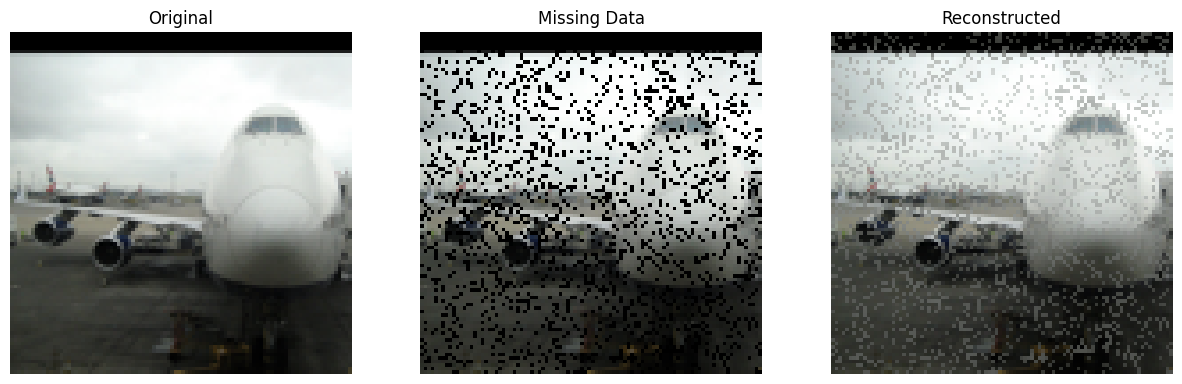

RMSE: 0.1592,  Time: 0.17s
Image shape: torch.Size([3, 96, 96])


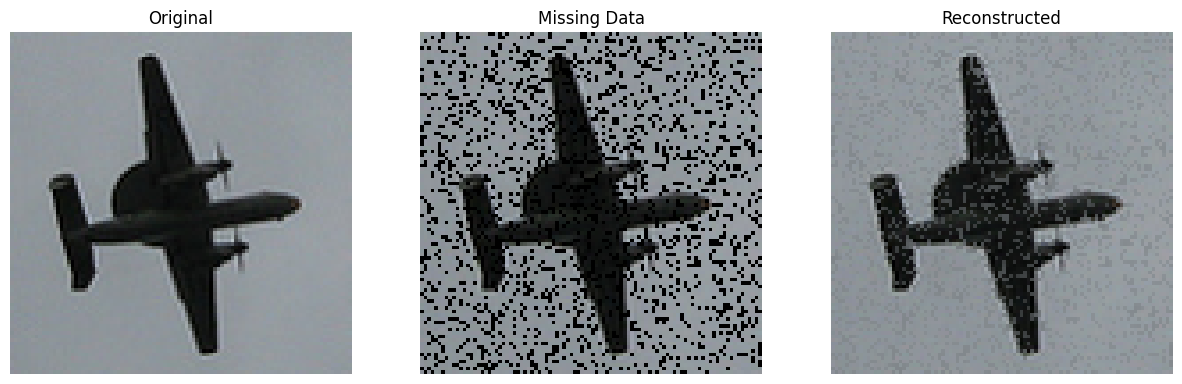

RMSE: 0.1018,  Time: 0.08s
Image shape: torch.Size([3, 96, 96])


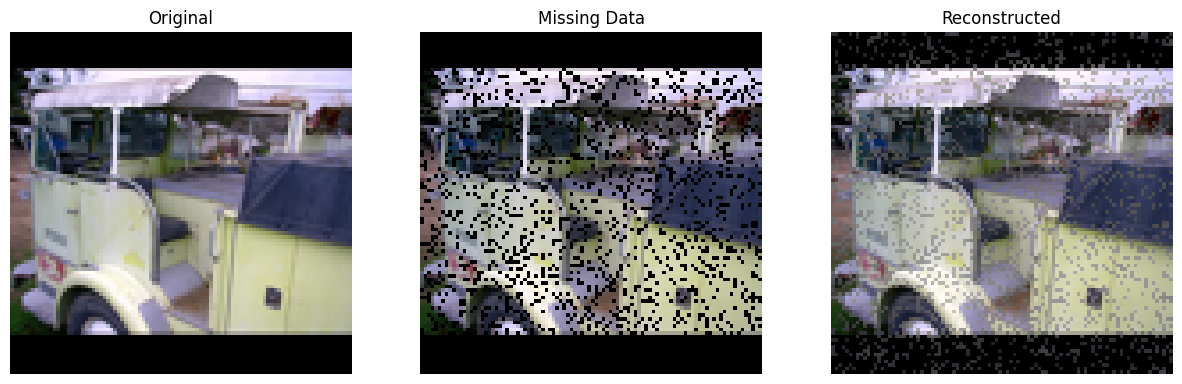

RMSE: 0.1620,  Time: 0.14s
Image shape: torch.Size([3, 96, 96])


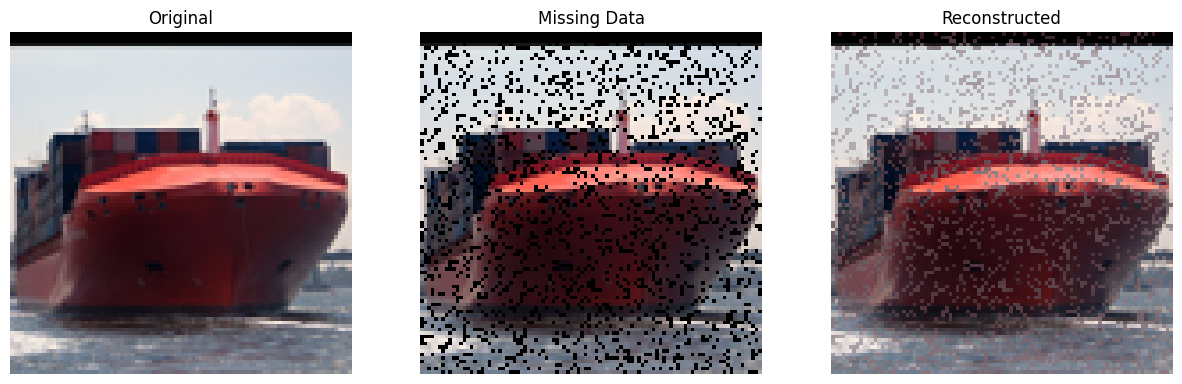

RMSE: 0.1622,  Time: 0.46s
Image shape: torch.Size([3, 96, 96])


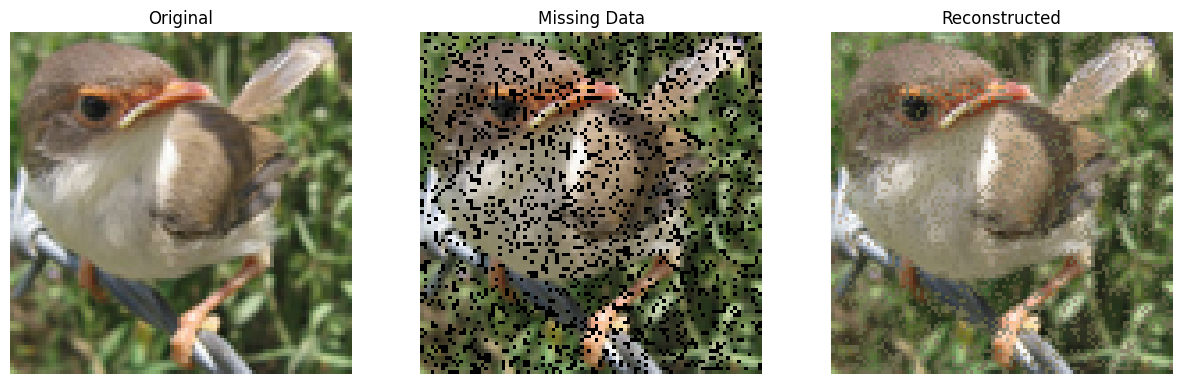

RMSE: 0.1034,  Time: 0.34s
Image shape: torch.Size([3, 96, 96])


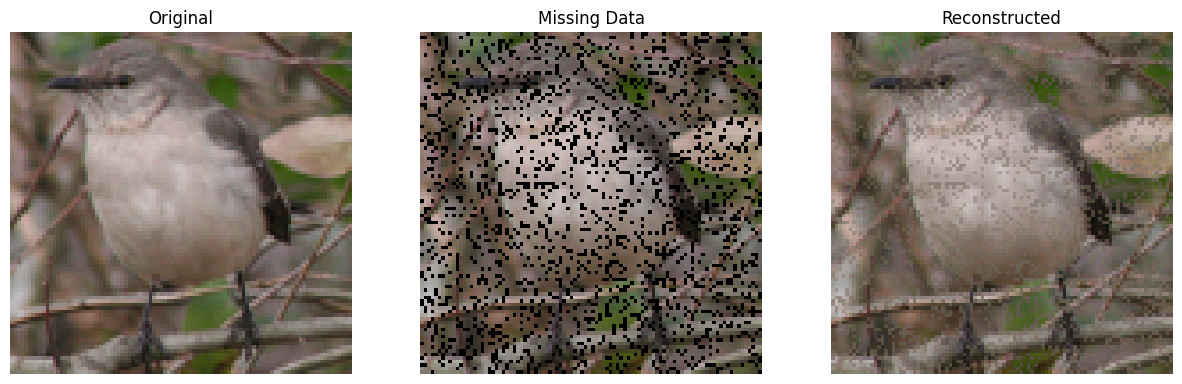

RMSE: 0.0874,  Time: 0.11s
Image shape: torch.Size([3, 96, 96])


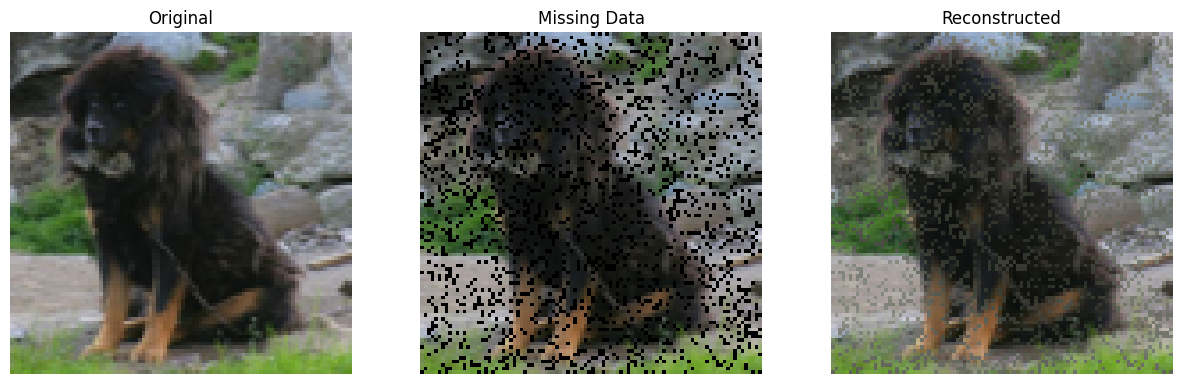

RMSE: 0.1027,  Time: 0.32s
Image shape: torch.Size([3, 96, 96])


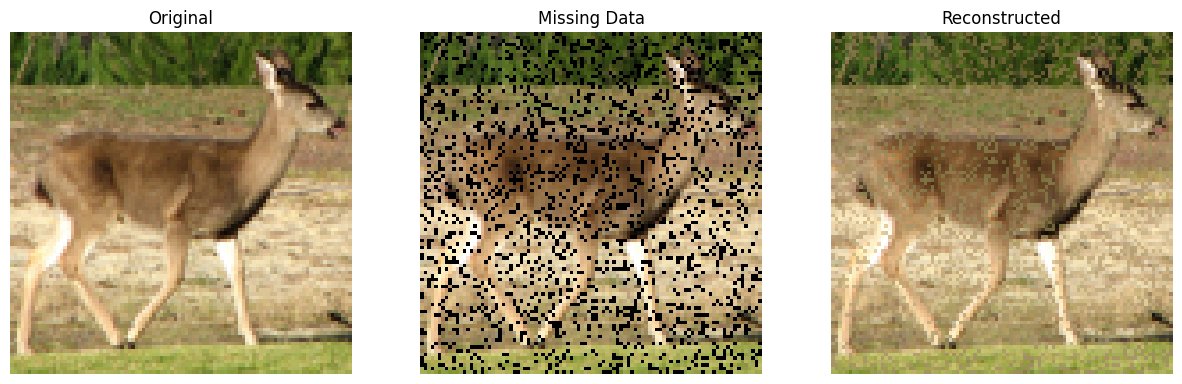

RMSE: 0.1107,  Time: 0.07s
Image shape: torch.Size([3, 96, 96])


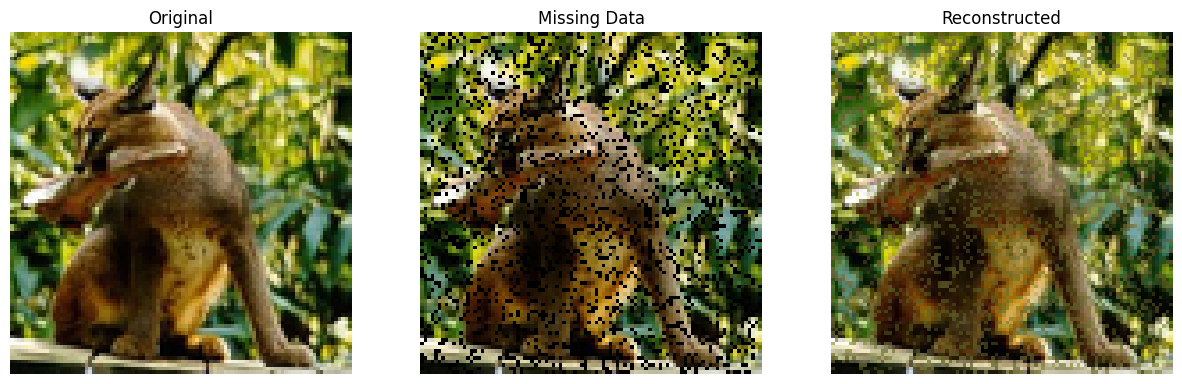

RMSE: 0.1514,  Time: 0.21s
Image shape: torch.Size([3, 96, 96])


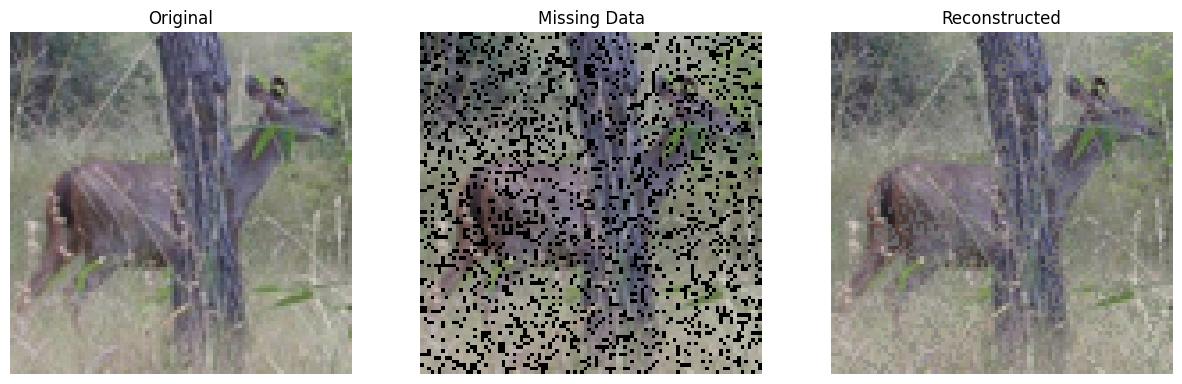

RMSE: 0.0706,  Time: 0.15s
Image shape: torch.Size([3, 96, 96])


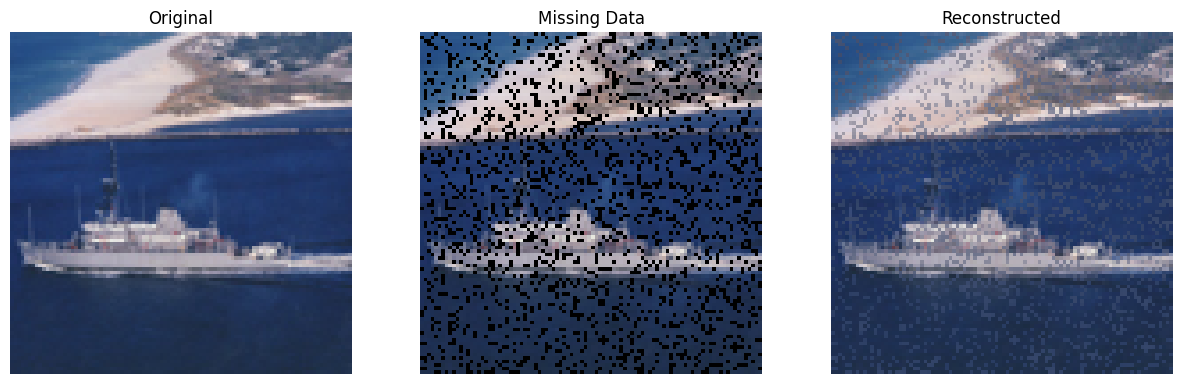

RMSE: 0.1049,  Time: 0.08s
Image shape: torch.Size([3, 96, 96])


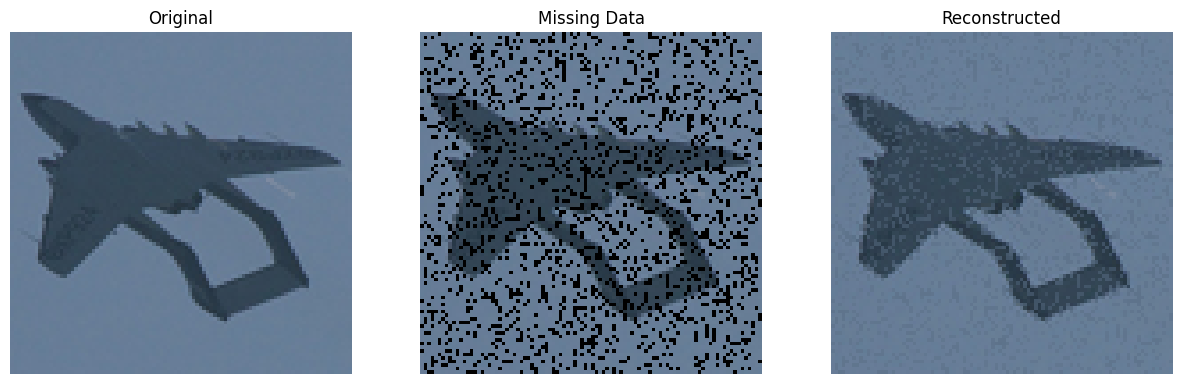

RMSE: 0.0546,  Time: 0.08s
Image shape: torch.Size([3, 96, 96])


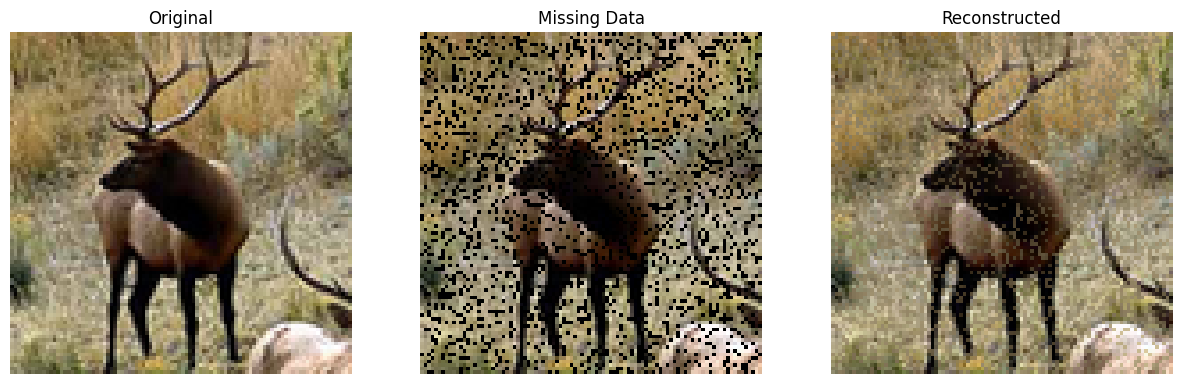

RMSE: 0.1283,  Time: 0.26s
Image shape: torch.Size([3, 96, 96])


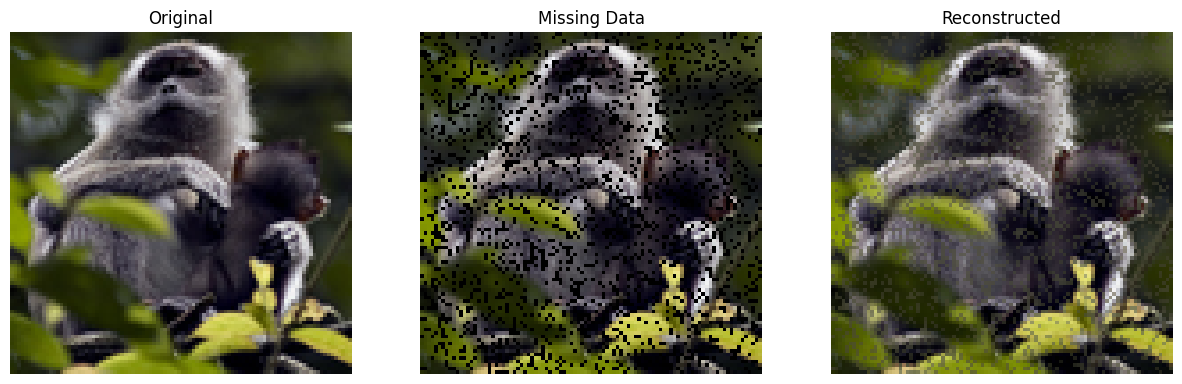

RMSE: 0.1198,  Time: 0.31s
Image shape: torch.Size([3, 96, 96])


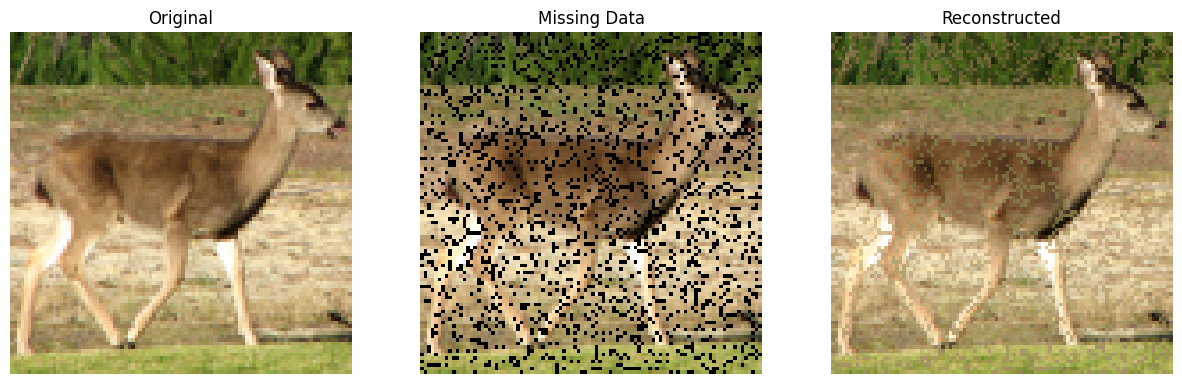

RMSE: 0.1113,  Time: 0.06s
Image shape: torch.Size([3, 96, 96])


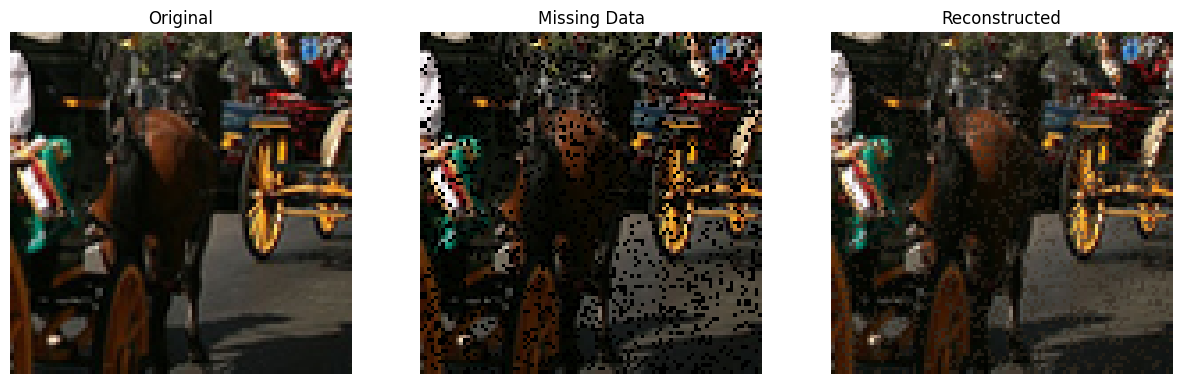

RMSE: 0.1170,  Time: 0.19s
Image shape: torch.Size([3, 96, 96])


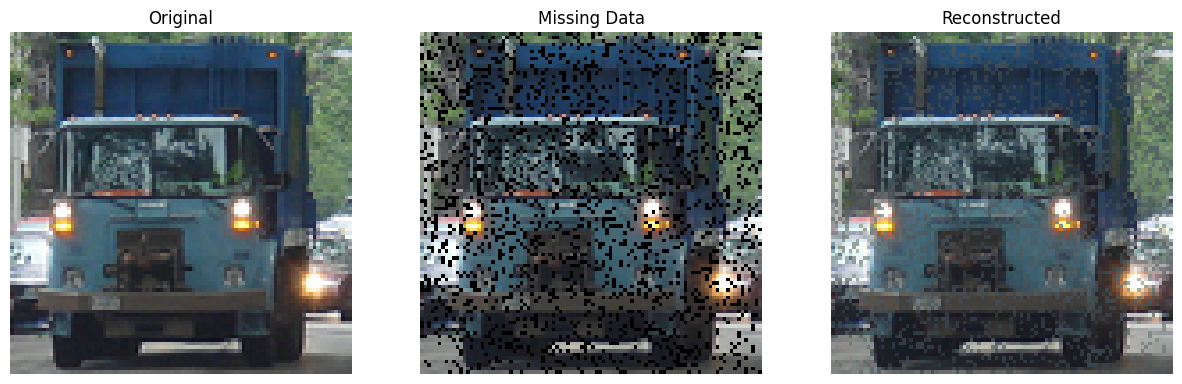

RMSE: 0.1126,  Time: 0.07s
Image shape: torch.Size([3, 96, 96])


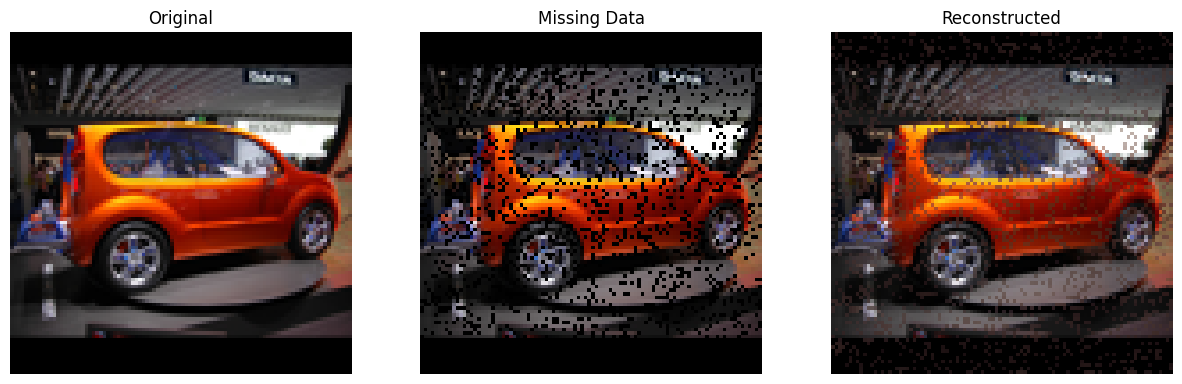

RMSE: 0.1289,  Time: 0.23s
Image shape: torch.Size([3, 96, 96])


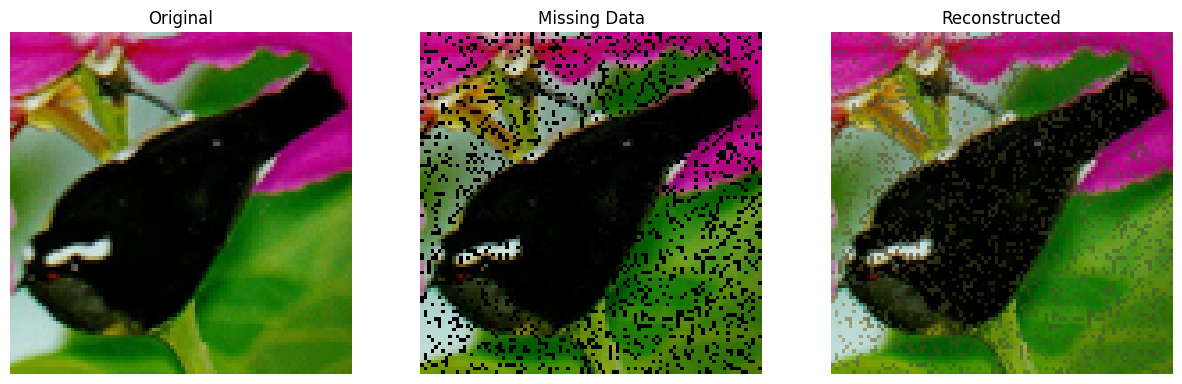

RMSE: 0.1318,  Time: 0.09s
Image shape: torch.Size([3, 96, 96])


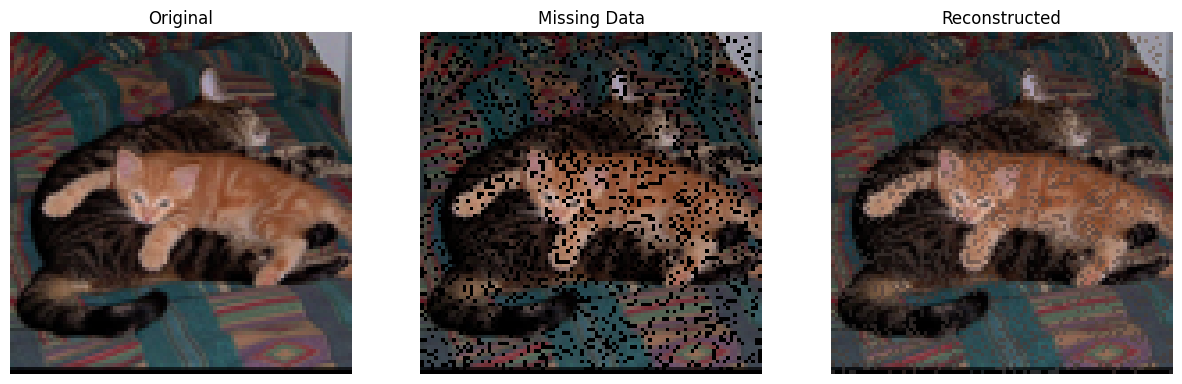

RMSE: 0.0888,  Time: 0.08s


In [72]:
test_ppca_on_colored_image(dataloader, patch_size=(4, 4), n_components=10, missing_rate=0.2)

### Example Implementation for Time Series Reconstruction

In [128]:
import torch
import numpy as np
import yfinance as yf

# Download the stock data
dataframe = yf.download(['AAPL'], start='2022-10-11', end='2024-12-01', interval='1d')['Close']
n_timesteps = len(dataframe)
n_features = 1
# Convert the data to a PyTorch tensor and move it to the GPU
data = torch.tensor(dataframe.values, dtype=torch.float32).cuda()
# data = torch.randn(n_timesteps, n_features).cuda()  # Move to GPU

# Introduce 20% missing values
missing_mask = torch.rand(n_timesteps, n_features).cuda() < 0.2
data_missing = data.clone()
data_missing[missing_mask] = torch.nan

def create_sliding_windows(time_series, window_size=50, stride=10):
    n_timesteps, n_features = time_series.shape
    windows = []
    
    for i in range(0, n_timesteps - window_size + 1, stride):
        window = time_series[i:i+window_size]
        windows.append(window)
    
    return torch.stack(windows)  # Shape: [n_windows, window_size, n_features]

# Example usage
window_size = 16  # Number of timesteps per window
stride = 10       # Overlap between windows
windows = create_sliding_windows(data_missing, window_size, stride)

# Flatten windows: [n_windows, window_size, n_features] → [n_windows, window_size * n_features]
windows_flat = windows.view(windows.shape[0], -1)

ppca = PPCA_GPU_Optimized(n_components=15, device="cuda")  # Adjust n_components
ppca.fit(windows_flat)

# Reconstruct windows
windows_recon_flat = ppca.reconstruct(windows_flat)
windows_recon = windows_recon_flat.view(windows.shape)  # Reshape to [n_windows, window_size, n_features]

# Aggregate overlapping windows into full time series
recon_series = torch.zeros_like(data_missing)
counts = torch.zeros_like(data_missing)

for i in range(len(windows_recon)):
    start = i * stride
    end = start + window_size
    recon_series[start:end] += windows_recon[i]
    counts[start:end] += 1

# Normalize overlapping regions
counts[counts == 0] = 1  # Avoid division by zero
recon_series /= counts

# Preserve observed values (optional)
recon_series[~torch.isnan(data_missing)] = data_missing[~torch.isnan(data_missing)]


# Compute RMSE for missing regions
missing_mask_np = missing_mask.detach().cpu().numpy()
data_missing_df = pd.DataFrame(data_missing.detach().cpu().numpy())


# Compute RMSE for PPCA
rmse_ppca = torch.sqrt(torch.mean((data[missing_mask] - recon_series[missing_mask])**2))

# Compute RMSE for Baseline
rmse_baseline = np.sqrt(np.mean((data_missing_df.interpolate().values - dataframe.values)**2))

# Compute variance of RMSE for PPCA
var_rmse_ppca = torch.var((data[missing_mask] - recon_series[missing_mask])**2)

# Compute variance of RMSE for Baseline
var_rmse_baseline = np.std((data_missing_df.interpolate().values - dataframe.values)**2)

# Create a dictionary to store the results
results = {
    "Metric": ["RMSE", "Std of RMSE"],
    "PPCA": [rmse_ppca.item(), var_rmse_ppca.item()],
    "Baseline": [rmse_baseline, var_rmse_baseline]
}

# Convert the dictionary to a pandas DataFrame
df_results = pd.DataFrame(results)

# Display the DataFrame
print("\nAggregate Results:")
df_results

[*********************100%***********************]  1 of 1 completed


Aggregate Results:


,Metric,PPCA,Baseline
0,RMSE,15.925749,1.022771
1,Std of RMSE,95018.640625,5.565310


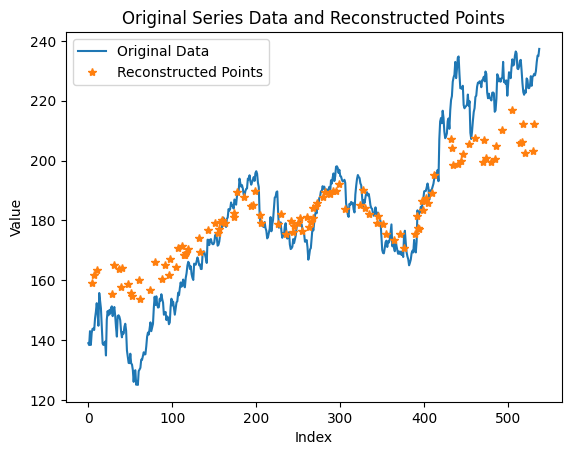

In [125]:
# Plot the original series data
plt.plot(data.detach().cpu().numpy(), label='Original Data')

# Plot the reconstructed points for missing values
plt.plot(
    [i for i, mask in enumerate(missing_mask) if mask],
    recon_series[missing_mask].detach().cpu().numpy(),
    '*',  # Use 'o' for points
    label='Reconstructed Points'
)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Original Series Data and Reconstructed Points')
plt.legend()

# Show the plot
plt.show()